# Linear Regression on Property Dataset
This notebook performs multiple linear regression on a property dataset using PySpark and tests all combinations of 4 features to find the best predictive model.  
You will:
- Load and clean the dataset
- Train regression models for different feature combinations
- Evaluate using MSE, RMSE, and R²
- Identify the best-performing feature set


## Install and Setup PySpark

In [2]:
# Install PySpark
!pip install pyspark

In [3]:
# Setup SparkSession
from pyspark.sql import SparkSession
import psutil

spark = SparkSession.builder \
    .appName("LinearRegression_spark") \
    .master("local[*]") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "2g") \
    .config("spark.executor.cores", "2") \
    .config("spark.sql.inMemoryColumnarStorage.compressed", "true") \
    .getOrCreate()

print(f"Spark UI available at: {spark.sparkContext.uiWebUrl}")
spark.sparkContext.setLogLevel("INFO")

# Monitor Resources
print(f"CPU Usage: {psutil.cpu_percent()}%")
print(f"Memory Usage: {psutil.virtual_memory().percent}%")


Spark UI available at: http://21feee59f7d0:4040
CPU Usage: 47.1%
Memory Usage: 16.9%


## Load Dataset
We load the property data from Google Drive and check its structure and completeness.


In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Load property dataset
df = spark.read.csv("/content/property.csv", header=True, inferSchema=True)
df.show(5)
print("Total Records:", df.count())
print("Total Partitions:", df.rdd.getNumPartitions())
df.printSchema()


+--------------+------------+-------------+----------+--------+------------------+
|Square_Footage|Num_Bedrooms|Num_Bathrooms|Year_Built|Lot_Size|             Price|
+--------------+------------+-------------+----------+--------+------------------+
|          1360|           2|            3|      1953|    7860| 303948.1373854071|
|          4272|           3|            3|      1997|    5292| 860386.2685075302|
|          3592|           4|            1|      1983|    9723| 734389.7538956215|
|           966|           6|            1|      1903|    4086| 226448.8070714377|
|          4926|           6|            4|      1944|    1081|1022486.2616704078|
+--------------+------------+-------------+----------+--------+------------------+
only showing top 5 rows

Total Records: 1000000
Total Partitions: 2
root
 |-- Square_Footage: integer (nullable = true)
 |-- Num_Bedrooms: integer (nullable = true)
 |-- Num_Bathrooms: integer (nullable = true)
 |-- Year_Built: integer (nullable = true)

In [7]:
# Summary & null check
df.describe().show()

from pyspark.sql.functions import col, isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+-------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+
|summary|   Square_Footage|     Num_Bedrooms|     Num_Bathrooms|       Year_Built|         Lot_Size|             Price|
+-------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+
|  count|          1000000|          1000000|           1000000|          1000000|          1000000|           1000000|
|   mean|      2750.657104|         3.501114|          2.500439|       1960.52736|      5502.373911| 581839.6653163614|
| stddev|1298.569362387213|1.708173784151257|1.1178528780094728|35.21780350510348|2598.885882999355|260685.36722644986|
|    min|              500|                1|                 1|             1900|             1000| 51495.71116919513|
|    max|             4999|                6|                 4|             2021|             9999|1123219.4691521737|
+-------+-----------------+-------------

## Split the Dataset
We split the dataset into training (70%) and testing (30%) for evaluation.


In [8]:
data_train, data_test = df.randomSplit([0.7, 0.3], seed=123)


## Run Regression on All 4-Feature Combinations
We automatically try every combination of 4 features from 5 possible options and evaluate their performance using MSE, RMSE, and R².


In [17]:
from itertools import combinations
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd

# Define feature set
all_features = ["Square_Footage", "Num_Bedrooms", "Num_Bathrooms", "Year_Built", "Lot_Size"]
results = []

# Loop through all 4-feature combinations
for i, feature_set in enumerate(combinations(all_features, 4), start=1):
    print(f"\n Combination {i}: {', '.join(feature_set)}")
    print("---------------------------------------------------------------------")

    # Assemble and scale
    assembler = VectorAssembler(inputCols=list(feature_set), outputCol="features")
    scaler = StandardScaler(inputCol="features", outputCol="scaled_Features")
    regressor = LinearRegression(labelCol='Price', featuresCol='scaled_Features')

    # Pipeline
    pipeline = Pipeline(stages=[assembler, scaler, regressor])

    # Fit on training data
    model = pipeline.fit(data_train)

    # Predictions
    train_predictions = model.transform(data_train)
    test_predictions = model.transform(data_test)

    # Evaluators
    evaluator_r2 = RegressionEvaluator(labelCol='Price', predictionCol='prediction', metricName='r2')
    evaluator_mse = RegressionEvaluator(labelCol='Price', predictionCol='prediction', metricName='mse')
    evaluator_rmse = RegressionEvaluator(labelCol='Price', predictionCol='prediction', metricName='rmse')

    # Metrics
    train_r2 = evaluator_r2.evaluate(train_predictions)
    test_r2 = evaluator_r2.evaluate(test_predictions)
    mse = evaluator_mse.evaluate(test_predictions)
    rmse = evaluator_rmse.evaluate(test_predictions)

    # Print for each iteration
    print(f"Train R² Score: {round(train_r2, 4)}")
    print(f"Test R² Score:  {round(test_r2, 4)}")
    print(f"MSE (Test):     {round(mse, 2)}")
    print(f"RMSE (Test):    {round(rmse, 2)}")

    # Save to results
    results.append({
        "Features": ", ".join(feature_set),
        "Train R2": round(train_r2, 4),
        "Test R2": round(test_r2, 4),
        "MSE (Test)": round(mse, 2),
        "RMSE (Test)": round(rmse, 2)
    })

# Final summary table
results_df = pd.DataFrame(results).sort_values(by="Test R2", ascending=False).reset_index(drop=True)

print("\n All combinations completed. Final summary table:")
results_df.head()  # You can use display() in Colab to render nicely



 Combination 1: Square_Footage, Num_Bedrooms, Num_Bathrooms, Year_Built
---------------------------------------------------------------------
Train R² Score: 0.9941
Test R² Score:  0.9941
MSE (Test):     397960542.4
RMSE (Test):    19948.95

 Combination 2: Square_Footage, Num_Bedrooms, Num_Bathrooms, Lot_Size
---------------------------------------------------------------------
Train R² Score: 0.9939
Test R² Score:  0.994
MSE (Test):     410447639.36
RMSE (Test):    20259.51

 Combination 3: Square_Footage, Num_Bedrooms, Year_Built, Lot_Size
---------------------------------------------------------------------
Train R² Score: 0.9939
Test R² Score:  0.994
MSE (Test):     409235722.31
RMSE (Test):    20229.58

 Combination 4: Square_Footage, Num_Bathrooms, Year_Built, Lot_Size
---------------------------------------------------------------------
Train R² Score: 0.993
Test R² Score:  0.9931
MSE (Test):     471222798.76
RMSE (Test):    21707.67

 Combination 5: Num_Bedrooms, Num_Bathroom

,Features,Train R2,Test R2,MSE (Test),RMSE (Test)
0,"Square_Footage, Num_Bedrooms, Num_Bathrooms, Y...",0.9941,0.9941,3.979605e+08,19948.95
1,"Square_Footage, Num_Bedrooms, Num_Bathrooms, L...",0.9939,0.9940,4.104476e+08,20259.51
2,"Square_Footage, Num_Bedrooms, Year_Built, Lot_...",0.9939,0.9940,4.092357e+08,20229.58
3,"Square_Footage, Num_Bathrooms, Year_Built, Lot...",0.9930,0.9931,4.712228e+08,21707.67
4,"Num_Bedrooms, Num_Bathrooms, Year_Built, Lot_Size",0.0015,0.0016,6.785833e+10,260496.32


_______________________________________________________________________


## Visualize Top 3 Models
Compare top 3 models using bar plots for MSE, RMSE, and R².


/tmp/ipython-input-21-3869642592.py:17: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


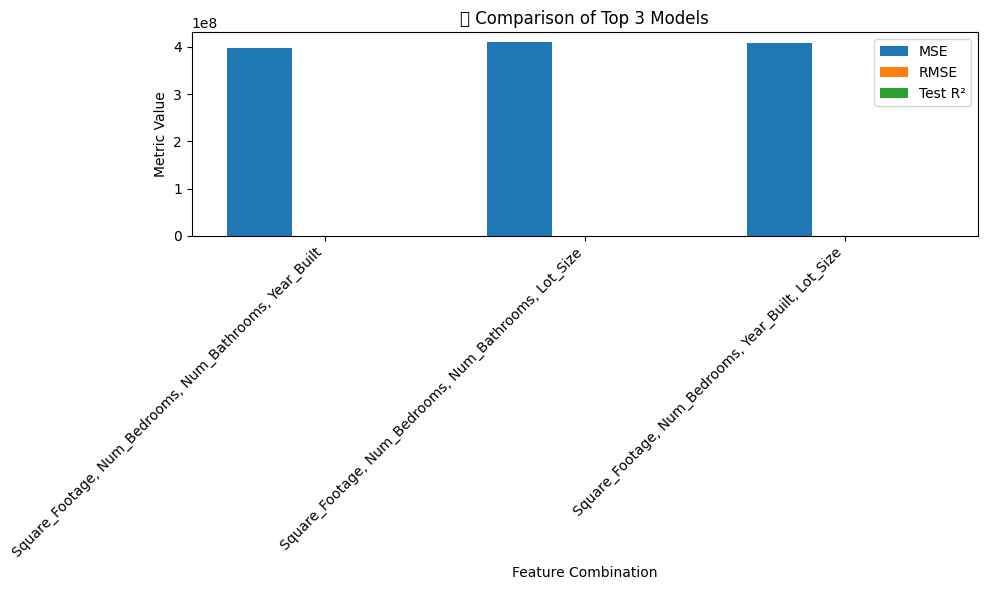

In [21]:
import numpy as np

top_3 = results_df.head(3)
x = np.arange(len(top_3))
bar_width = 0.25

plt.figure(figsize=(10,6))
plt.bar(x - bar_width, top_3['MSE (Test)'], width=bar_width, label='MSE')
plt.bar(x, top_3['RMSE (Test)'], width=bar_width, label='RMSE')
plt.bar(x + bar_width, top_3['Test R2'], width=bar_width, label='Test R²')

plt.xticks(x, top_3['Features'], rotation=45, ha='right')
plt.xlabel("Feature Combination")
plt.ylabel("Metric Value")
plt.title("🔎 Comparison of Top 3 Models")
plt.legend()
plt.tight_layout()
plt.show()


## Full Results Table
View all feature combinations and their evaluation metrics.


In [23]:
print(results_df.to_string(index=False))


                                               Features  Train R2  Test R2   MSE (Test)  RMSE (Test)
Square_Footage, Num_Bedrooms, Num_Bathrooms, Year_Built    0.9941   0.9941 3.979605e+08     19948.95
  Square_Footage, Num_Bedrooms, Num_Bathrooms, Lot_Size    0.9939   0.9940 4.104476e+08     20259.51
     Square_Footage, Num_Bedrooms, Year_Built, Lot_Size    0.9939   0.9940 4.092357e+08     20229.58
    Square_Footage, Num_Bathrooms, Year_Built, Lot_Size    0.9930   0.9931 4.712228e+08     21707.67
      Num_Bedrooms, Num_Bathrooms, Year_Built, Lot_Size    0.0015   0.0016 6.785833e+10    260496.32
